In [1]:
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import seaborn
import pandas as pd
from sklearn import datasets
import re
from cycler import cycler
%matplotlib inline
plt.style.use('default')

## Nearest neighbor classifier

In [2]:
iris = datasets.load_iris(return_X_y=False)

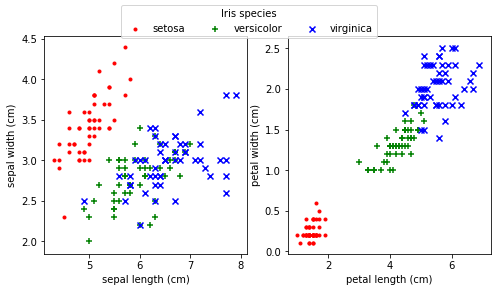

In [3]:
def iris_simple_scatter(ax, x_ix=0, y_ix=1, iris=iris, cy=cycler(color=list('rgb'))):
    '''
    Create a figure with one scatter plot of the iris data
    Arguments
    ax: an axes object
    x_ix: the column index of iris data that will be plotted on the x-axis
    y_ix: the column index of iris data that will be plotted on the y-axis
    iris: the iris data
    cy: color cycler object
    Value:
    the resulting figure and axes object
    '''
    ax.set_prop_cycle(cy)
    for i in set(iris.target):
        x = iris.data[iris.target == i, x_ix]
        y = iris.data[iris.target == i, y_ix]
        ax.scatter(x, y, marker='.+x'[i], label=iris.target_names[i])
    ax.set_xlabel(iris.feature_names[x_ix])
    ax.set_ylabel(iris.feature_names[y_ix])
    return((fig, ax))

fig, ax = plt.subplots(1, 2, figsize=plt.figaspect(1/2))
iris_simple_scatter(ax[0], 0, 1)
iris_simple_scatter(ax[1], 2, 3)
fig.legend(*ax[0].get_legend_handles_labels(), ncol=3, loc='upper center', title='Iris species')

Prepare training and test data

In [4]:
np.random.seed(1976)
indices = np.random.permutation(len(iris.data))
iris_X_train = iris.data[indices[:-10]]
iris_y_train = iris.target[indices[:-10]]
iris_X_test = iris.data[indices[-10:]]
iris_y_test = iris.target[indices[-10:]]

Making and fitting an estimator object

In [5]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier()
knn.fit(X=iris_X_train, y=iris_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [6]:
knn.predict(iris_X_test)

array([1, 2, 2, 0, 1, 0, 2, 1, 0, 2])

In [7]:
iris_y_test

array([1, 2, 1, 0, 1, 0, 2, 1, 0, 2])

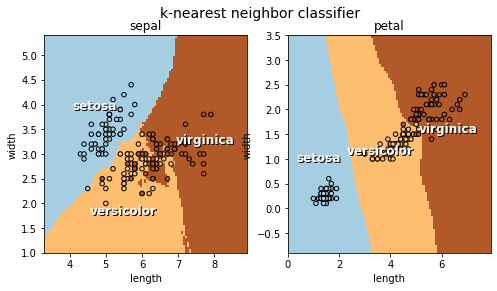

In [8]:
def iris_decisionb(ax, feature, cls, gridsize=100):
    ix = [(lambda x: re.search(feature, iris.feature_names[x]) and x)(i) for i in range(len(iris.feature_names))]
    ix = np.array(ix)
    ix = ix[[y is not None for y in ix]].astype(np.int32)
    X = iris.data[:, ix]
    # fit classifier
    cls.fit(X=X, y=iris.target)
    # create meshgrid on which to evaluate the estimator
    x0 = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, gridsize)
    x1 = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, gridsize)
    xx0, xx1 = np.meshgrid(x0, x1)
    # test data for prediction: a 10,000 * 2 array
    X_test = np.vstack((xx0.ravel(), xx1.ravel())).T
    # predict and reshape according to the meshgrid
    y_pred = cls.predict(X=X_test).reshape(xx0.shape)
    # plot the decision boundaries
    cmap = 'Paired'
    ax.pcolormesh(xx0, xx1, y_pred, cmap=cmap)
    ax.scatter(X[:, 0], X[:, 1], c=iris.target, cmap=cmap, edgecolor='k', s=20)
    ax.set_title(feature)
    ax.set_xlabel('length')
    ax.set_ylabel('width')
    # calculating average feature values for each class
    def pred_class_avg(cls):
        avg = tuple((lambda z: np.average(z.flatten()[y_pred.flatten() == cls]))(x) for x in (xx0, xx1))
        return(avg)
    avgs = [pred_class_avg(i) for i in range(len(iris.target_names))]
    avgs = dict(zip(iris.target_names, avgs))
    # https://matplotlib.org/tutorials/advanced/transforms_tutorial.html#using-offset-transforms-to-create-a-shadow-effect
    dx, dy = 1/72., -1/72.
    import matplotlib.transforms as transforms
    shadow_transform = transforms.offset_copy(ax.transData, fig, dx, dy, units='inches')
    # adding speices name to plot
    args = {'ha': 'center', 'va': 'center', 'weight': 'bold', 'color': 'k', 'size': 12}
    [ax.text(*avgs[n], n, **args, transform=shadow_transform) for n in iris.target_names]
    args['color'] = 'w'
    [ax.text(*avgs[n], n, **args) for n in iris.target_names]
    return(avgs)

def twopanel_cls(cls, suptitle):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.5))    
    iris_decisionb(ax[0], 'sepal', cls)
    iris_decisionb(ax[1], 'petal', cls)
    ax[0].set_ylabel('width')
    fig.suptitle(suptitle, size=14)
    return((fig, ax))

fig, ax = twopanel_cls(neighbors.KNeighborsClassifier(), 'k-nearest neighbor classifier')

## Linear model

Get data and fit model

In [9]:
diabetes = datasets.load_diabetes(return_X_y=False)
np.random.seed(1976)
indices = np.random.permutation(len(diabetes.target))
diabetes_X_train = diabetes.data[indices[:-20]]
diabetes_y_train = diabetes.target[indices[:-20]]
diabetes_X_test = diabetes.data[indices[-20:]]
diabetes_y_test = diabetes.target[indices[-20:]]
from sklearn import linear_model
nlm = linear_model.LinearRegression()
nlm.fit(X=diabetes_X_train, y=diabetes_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Look at the attributes created by the fit 

In [10]:
set(dir(nlm)) - set(dir(linear_model.LinearRegression()))

{'_residues', 'coef_', 'intercept_', 'rank_', 'singular_'}

The estimated coefficients

In [11]:
dict(zip(diabetes.feature_names, nlm.coef_))

{'age': -6.957176254771265,
 'sex': -236.8824200401544,
 'bmi': 514.2039736205772,
 'bp': 314.1296300116925,
 's1': -747.6235003925527,
 's2': 431.7814234571935,
 's3': 106.29691703797818,
 's4': 180.00898240892803,
 's5': 737.8645060237878,
 's6': 87.60779815406775}

Estimated intercept and rank

In [12]:
nlm.intercept_, nlm.rank_

(152.1032414856735, 10)

Predict diabetes progression using the test data

[Text(0, 0.5, 'test data'),
 Text(0.5, 0, 'prediction'),
 Text(0.5, 1.0, 'Diabetes progression')]

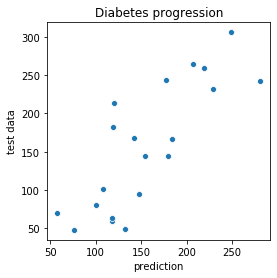

In [13]:
fig, ax = plt.subplots(figsize=plt.figaspect(1))
seaborn.scatterplot(x=nlm.predict(diabetes_X_test), y=diabetes_y_test)
ax.set(xlabel='prediction', ylabel='test data', title='Diabetes progression')

The [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) or $r^2$ score is the proportion of the variance in the response (diabetes progression) that is determined by the predictors.  It is defined as
$$
r^2 = \frac{\mathrm{SS}_\mathrm{reg}}{\mathrm{SS}_\mathrm{tot}} = 1 - \frac{\mathrm{SS}_\mathrm{res}}{\mathrm{SS}_\mathrm{tot}} \\
$$
since the variance decomposes as $\mathrm{SS}_\mathrm{tot} = \mathrm{SS}_\mathrm{res} + \mathrm{SS}_\mathrm{reg}$, where
$$
\begin{eqnarray}
    \mathrm{SS}_\mathrm{tot} &=& \sum_i (y_i - \bar{y})^2 \; \text{(total sum of squares)}\\
    \mathrm{SS}_\mathrm{res} &=& \sum_i (y_i - \hat{y}_i)^2 \; \text{(residual sum of squares)} \\
    \mathrm{SS}_\mathrm{reg} &=& \sum_i (\hat{y}_i - \bar{y})^2 \; \text{(regression sum of squares)}
\end{eqnarray}
$$

In scikit-learn $r^2$ is known as (regression) score.

In [14]:
nlm.score(diabetes_X_test, diabetes_y_test)

0.6439264072607552

The out of sample mean squared prediction error ([see wikipedia](https://en.wikipedia.org/wiki/Mean_squared_prediction_error)) is easily calculated

In [15]:
np.mean((nlm.predict(X=diabetes_X_test) - diabetes_y_test) ** 2)

2331.163961360852

### Shrinkage

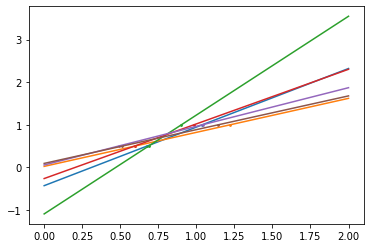

In [16]:
X = np.c_[ .5, 1].T
y = [.5, 1]
test = np.c_[ 0, 2].T

def multipred(regr, X=X, y=y, test=test, k=6):
    plt.figure()
    np.random.seed(0)
    for _ in range(k): 
        this_X = .1 * np.random.normal(size=(2, 1)) + X
        regr.fit(this_X, y)
        plt.plot(test, regr.predict(test))
        plt.scatter(this_X, y, s=3)
        
multipred(regr=linear_model.LinearRegression())

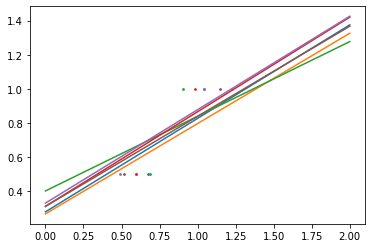

In [17]:
multipred(regr=linear_model.Ridge(alpha=.1))

$\alpha$ is the regularization parameter of ridge regression.  Higher $\alpha$ means more regularization but also more shrinkage bias.  The $r^2$ score

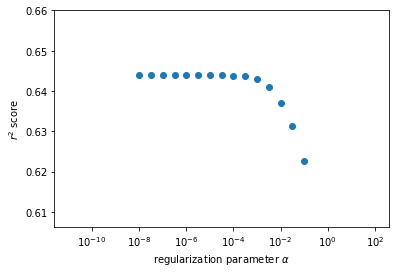

In [18]:
alphas = np.logspace(-8, -1, 15)
regr=linear_model.Ridge()
scores = [regr.set_params(alpha=a).fit(X=diabetes_X_train, y=diabetes_y_train).score(X=diabetes_X_test, y=diabetes_y_test) for a in alphas]
def scoreplot(alphas, scores):
    fig, ax = plt.subplots(1)
    ax.set_xscale('log')
    ax.set_xlabel('regularization parameter $\\alpha$')
    ax.set_ylabel('$r^2$ score')
    ax.scatter(alphas, scores)
scoreplot(alphas,scores)

The LASSO selects the most informative

/home/attila/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8798.926167784259, tolerance: 248.96157559241706
  positive)
/home/attila/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1044.523414122872, tolerance: 248.96157559241706
  positive)


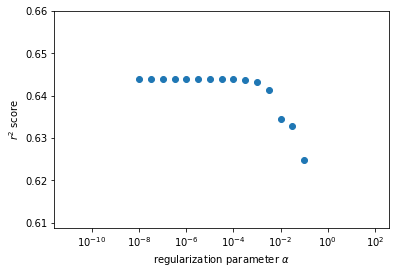

In [19]:
regr = linear_model.Lasso()
scores = [regr.set_params(alpha=a).fit(X=diabetes_X_train, y=diabetes_y_train).score(X=diabetes_X_test, y=diabetes_y_test) for a in alphas]
scoreplot(alphas,scores)

In [20]:
best_alpha = alphas[scores.index(max(scores))]
regr.alpha = best_alpha
regr.fit(X=diabetes_X_train, y=diabetes_y_train)
pd.DataFrame({'feature': diabetes.feature_names, 'coef': regr.coef_})

/home/attila/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8798.926167784259, tolerance: 248.96157559241706
  positive)


,feature,coef
0,age,-6.957166
1,sex,-236.882412
2,bmi,514.203978
3,bp,314.129622
4,s1,-747.622743
5,s2,431.780835
6,s3,106.296562
7,s4,180.008861
8,s5,737.864230
9,s6,87.607797


## Classification

Logistic regression is in general preferrable in classification to linear regression

In [21]:
'''
Inverse of regularization strength; must be a positive float.
Like in support vector machines, smaller values specify stronger
regularization.
'''
logi = linear_model.LogisticRegression(C=1e5, solver='liblinear', multi_class='auto')
logi.fit(X=iris_X_train, y=iris_y_train)
pd.DataFrame({'actual class': iris_y_test, 'predicted class': logi.predict(X=iris_X_test)})

,actual class,predicted class
0,1,1
1,2,2
2,1,2
3,0,0
4,1,1
5,0,0
6,2,2
7,1,1
8,0,0
9,2,2


Now obtain decision boundaries based on either the petal or sepal portion of the data

(<Figure size 576x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f942344d910>,
       dtype=object))

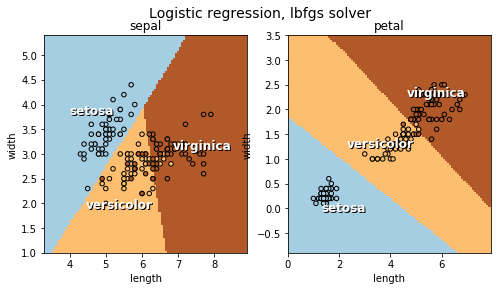

In [22]:
twopanel_cls(linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='auto'), \
             'Logistic regression, lbfgs solver')

The solver affects the classifier

(<Figure size 576x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f94311e7850>,
       dtype=object))

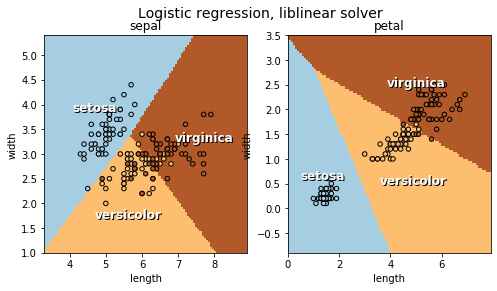

In [23]:
twopanel_cls(linear_model.LogisticRegression(C=1e5, solver='liblinear', multi_class='auto'), \
             'Logistic regression, liblinear solver')

## Support Vector Machines

Here we apply SVM classifiers with different kernels to the iris data set

(<Figure size 576x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f942371bd10>,
       dtype=object))

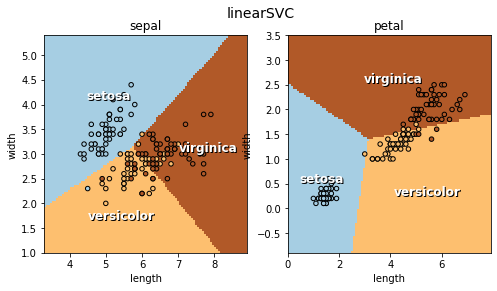

In [24]:
from sklearn import svm
twopanel_cls(svm.LinearSVC(max_iter=1e4), 'linearSVC')

(<Figure size 576x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f943013d9d0>,
       dtype=object))

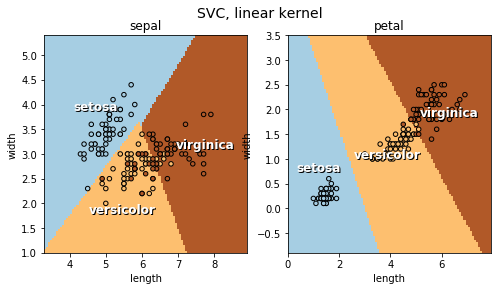

In [25]:
twopanel_cls(svm.SVC(kernel='linear', gamma='scale'), 'SVC, linear kernel')

(<Figure size 576x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f942356edd0>,
       dtype=object))

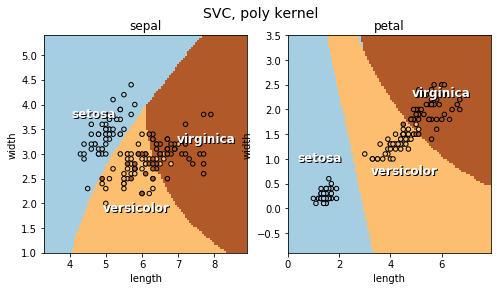

In [26]:
twopanel_cls(svm.SVC(kernel='poly', gamma='scale'), 'SVC, poly kernel')

(<Figure size 576x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9430033450>,
       dtype=object))

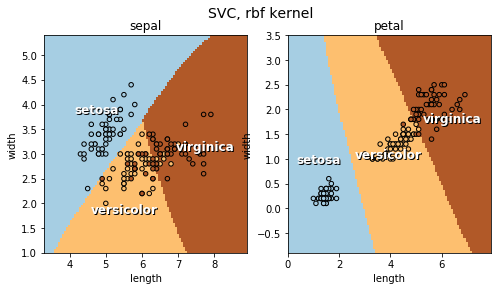

In [27]:
twopanel_cls(svm.SVC(kernel='rbf', gamma='scale'), 'SVC, rbf kernel')

/home/attila/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/attila/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(<Figure size 576x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f94232cf1d0>,
       dtype=object))

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


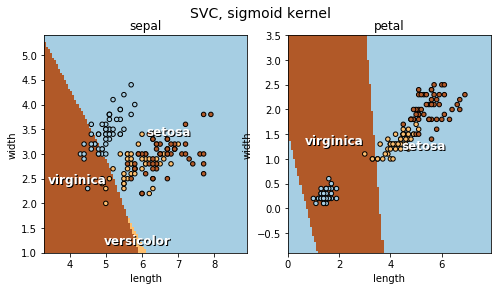

In [28]:
twopanel_cls(svm.SVC(kernel='sigmoid', gamma='scale'), 'SVC, sigmoid kernel')

In [29]:
%connect_info

{
  "shell_port": 44561,
  "iopub_port": 43099,
  "stdin_port": 56997,
  "control_port": 47271,
  "hb_port": 54353,
  "ip": "127.0.0.1",
  "key": "23c22834-64ab5b41f92b0f913396717f",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-0f944e8e-0433-43e8-909e-8526b0c84924.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
